# Testing tf-agents library

A lot of this code was pulling from TF-Agents DQN tutorial as well as other TF-Agents tutorial pages:
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

At a high level we will do the following:

1) Get an environment
2) Get an agent
3) Get a policy
4) 

In [1]:
from tqdm import tqdm
from wordle_rl import WordleEnv

# import gym

import tensorflow as tf
import numpy as np

import tf_agents
import reverb

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_py_policy
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils

2022-02-15 23:37:05.133314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-15 23:37:05.133360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1) Hyperparameters of this demo

In [3]:
env_name = "wordle" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

### 2) Convert Gym envs to TFPy envs

Two things are happening here:
1) We're initializing a separate train and eval env
2) We're convering our custom OpenAI Gym env into a TF python env

In [4]:
env = WordleEnv("config.json")
env = tf_agents.environments.gym_wrapper.GymWrapper(env)

gym_train_env = WordleEnv("config.json")
gym_eval_env = WordleEnv("config.json")

collect_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_train_env)
eval_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_eval_env)

# collect_env = tf_py_environment.TFPyEnvironment(py_train_env)
# eval_env = tf_py_environment.TFPyEnvironment(py_eval_env)

In [5]:
use_gpu = False

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [6]:
# tf_env = tf_py_environment.TFPyEnvironment(env)
# # reset() creates the initial time_step after resetting the environment.
# time_step = tf_env.reset()
# num_steps = 3
# transitions = []
# reward = 0
# for i in range(num_steps):
#     action = tf.constant([i % 2])
#     # applies the action and returns the new TimeStep.
#     next_time_step = tf_env.step(action)
#     transitions.append([time_step, action, next_time_step])
#     reward += next_time_step.reward
#     time_step = next_time_step

# np_transitions = tf.nest.map_structure(lambda x: x.numpy(), transitions)
# print('\n'.join(map(str, np_transitions)))
# print('Total reward:', reward.numpy())

### 3) Define a TF agent

This time we'll use the soft actor-critic model (SAC). 

In [6]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

In [7]:
with strategy.scope():
    critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

In [8]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [9]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

    tf_agent.initialize()

2022-02-15 23:37:19.813802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-15 23:37:19.813865: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-15 23:37:19.813894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f5bfd35a90d8): /proc/driver/nvidia/version does not exist
2022-02-15 23:37:19.814203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NotImplementedError: SacAgent does not currently support discrete actions. Action spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(10656))
  In call to configurable 'SacAgent' (<class 'tf_agents.agents.sac.sac_agent.SacAgent'>)

### 4) Define a Replay Buffer

This is technically optional. The replay buffer will improve data efficiency, that is we will get more information from each game as the replay buffer lets us replay games to see different outcomes from certain states.

In [11]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(10656)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(60,), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(29, dtype=uint8)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [12]:
# table_name = 'uniform_table'
# replay_buffer_signature = tensor_spec.from_spec(
#       agent.collect_data_spec)
# replay_buffer_signature = tensor_spec.add_outer_dim(
#     replay_buffer_signature)

# table = reverb.Table(
#     table_name,
#     max_size=replay_buffer_max_length,
#     sampler=reverb.selectors.Uniform(),
#     remover=reverb.selectors.Fifo(),
#     rate_limiter=reverb.rate_limiters.MinSize(1),
#     signature=replay_buffer_signature)

# reverb_server = reverb.Server([table])

# replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
#     agent.collect_data_spec,
#     table_name=table_name,
#     sequence_length=2,
#     local_server=reverb_server)

# rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
#   replay_buffer.py_client,
#   table_name,
#   sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmprlz9zac4.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmprlz9zac4
[reverb/cc/platform/default/server.cc:71] Started replay server on port 15931


### 5) Train our agent

In [13]:
time_step = env.reset()

In [19]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

In [16]:


replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [21]:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [24]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [78]:
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}



# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()

# Create a driver to collect experience.
collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2)

iterator = iter(dataset)

for _ in tqdm(range(num_iterations)):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_op.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    # print(time_step)
    experience, unused_info = next(iterator)
    # print(experience)
    train_loss = agent.train(experience).loss
    # print(train_loss)
    step = agent.train_step_counter.numpy()
    # print(step)
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

  5%|▌         | 5001/100000 [11:18<5:34:40,  4.73it/s]

step = 5000: Average Return = 144.0


 10%|▉         | 9999/100000 [22:38<3:17:28,  7.60it/s]

step = 10000: loss = 1589.5849609375


 10%|█         | 10001/100000 [22:39<5:19:44,  4.69it/s]

step = 10000: Average Return = 106.5


 15%|█▌        | 15001/100000 [33:56<5:09:17,  4.58it/s]

step = 15000: Average Return = 139.60000610351562


 20%|█▉        | 19999/100000 [45:16<2:58:45,  7.46it/s]

step = 20000: loss = 113190.8125


 20%|██        | 20001/100000 [45:16<4:37:31,  4.80it/s]

step = 20000: Average Return = 196.1999969482422


 25%|██▌       | 25001/100000 [56:35<4:21:51,  4.77it/s]

step = 25000: Average Return = 150.1999969482422


 30%|██▉       | 29999/100000 [1:07:55<2:37:07,  7.43it/s]

step = 30000: loss = 9947.193359375


 30%|███       | 30001/100000 [1:07:55<4:10:13,  4.66it/s]

step = 30000: Average Return = 189.1999969482422


 35%|███▌      | 35001/100000 [1:19:15<3:50:54,  4.69it/s]

step = 35000: Average Return = 209.0


 40%|███▉      | 39999/100000 [1:30:35<2:12:16,  7.56it/s]

step = 40000: loss = 3950.211181640625


 40%|████      | 40001/100000 [1:30:36<3:32:52,  4.70it/s]

step = 40000: Average Return = 324.79998779296875


 45%|████▌     | 45001/100000 [1:41:55<3:10:04,  4.82it/s]

step = 45000: Average Return = 115.69999694824219


 50%|████▉     | 49999/100000 [1:53:09<1:52:22,  7.42it/s]

step = 50000: loss = 2345.0908203125


 50%|█████     | 50001/100000 [1:53:10<2:55:49,  4.74it/s]

step = 50000: Average Return = 225.8000030517578


 55%|█████▌    | 55001/100000 [2:04:27<2:35:49,  4.81it/s]

step = 55000: Average Return = 126.9000015258789


 60%|█████▉    | 59999/100000 [2:15:44<1:28:18,  7.55it/s]

step = 60000: loss = 2896.36572265625


 60%|██████    | 60001/100000 [2:15:45<2:18:14,  4.82it/s]

step = 60000: Average Return = 303.70001220703125


 65%|██████▌   | 65001/100000 [2:27:03<2:03:07,  4.74it/s]

step = 65000: Average Return = 165.6999969482422


 70%|██████▉   | 69999/100000 [2:38:21<1:10:19,  7.11it/s]

step = 70000: loss = 3536.06005859375


 70%|███████   | 70001/100000 [2:38:22<1:48:32,  4.61it/s]

step = 70000: Average Return = 125.80000305175781


 75%|███████▌  | 75001/100000 [2:49:46<1:29:04,  4.68it/s]

step = 75000: Average Return = 183.8000030517578


 80%|███████▉  | 79999/100000 [3:01:06<47:15,  7.05it/s]  

step = 80000: loss = 1789.4822998046875


 80%|████████  | 80001/100000 [3:01:06<1:14:17,  4.49it/s]

step = 80000: Average Return = 221.3000030517578


 85%|████████▌ | 85001/100000 [3:12:28<50:57,  4.91it/s]  

step = 85000: Average Return = 164.8000030517578


 90%|████████▉ | 89999/100000 [3:23:38<22:37,  7.37it/s]  

step = 90000: loss = 4584.96728515625


 90%|█████████ | 90001/100000 [3:23:39<35:09,  4.74it/s]

step = 90000: Average Return = 235.60000610351562


 95%|█████████▌| 95001/100000 [3:34:49<17:40,  4.71it/s]

step = 95000: Average Return = 158.89999389648438


100%|█████████▉| 99999/100000 [3:45:59<00:00,  7.58it/s]

step = 100000: loss = 8874.814453125


100%|██████████| 100000/100000 [3:46:00<00:00,  7.37it/s]

step = 100000: Average Return = 114.19999694824219


### 6) Evaluate our agent

We need a way to see how good our policy is performing on our environment

In [31]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

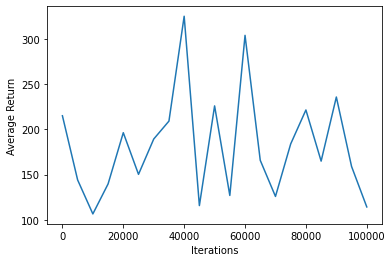

In [79]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)

In [14]:
def test_env(environment, policy, num_episodes=10):

    total_return = 0.0

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
    total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [92]:
time_step = eval_env.reset()

In [93]:
time_step[3]

<tf.Tensor: shape=(1, 60), dtype=uint8, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)>

In [94]:
time_step.is_first()

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

In [95]:
action_step = agent.policy.action(time_step)

In [96]:
action_step

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([524])>, state=(), info=())

In [97]:
gym_train_env.valid_words[int(action_step.action.numpy())]

'aurar'

In [98]:
time_step = eval_env.step(action_step.action)

In [99]:
time_step[3].numpy().reshape((2,6,5))

array([[[ 1, 21, 18,  1, 18],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[27, 29, 27, 27, 27],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]], dtype=uint8)

In [100]:
action_step = agent.policy.action(time_step)

In [101]:
gym_train_env.valid_words[int(action_step.action.numpy())]

'waits'

In [103]:
time_step = eval_env.step(action_step.action)

In [104]:
time_step[3].numpy().reshape((2,6,5))

array([[[ 1, 21, 18,  1, 18],
        [23,  1,  9, 20, 19],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[27, 29, 27, 27, 27],
        [27, 27, 27, 28, 27],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]], dtype=uint8)

In [ ]:
action_step = agent.policy.action(time_step)

In [ ]:
gym_train_env.valid_words[int(action_step.action.numpy())]

In [91]:
time_step = eval_env.step(action_step.action)

In [69]:
time_step[3].numpy().reshape((2,6,5))

array([[[ 3,  1, 13, 21, 19],
        [ 4,  1, 25,  1, 14],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[27, 27, 27, 27, 29],
        [28, 27, 27, 27, 27],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]], dtype=uint8)

In [70]:
action_step = agent.policy.action(time_step)

In [71]:
gym_train_env.valid_words[int(action_step.action.numpy())]

'dayan'

In [73]:
time_step = eval_env.step(action_step.action)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 60), dtype=uint8, numpy=
array([[ 3,  1, 13, 21, 19,  4,  1, 25,  1, 14,  4,  1, 25,  1, 14,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 27, 27,
        27, 27, 29, 28, 27, 27, 27, 27, 28, 27, 27, 27, 27,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint8)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>})

In [74]:
time_step[3].numpy().reshape((2,6,5))

array([[[ 3,  1, 13, 21, 19],
        [ 4,  1, 25,  1, 14],
        [ 4,  1, 25,  1, 14],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[27, 27, 27, 27, 29],
        [28, 27, 27, 27, 27],
        [28, 27, 27, 27, 27],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]], dtype=uint8)

In [75]:
action_step = agent.policy.action(time_step)

In [76]:
gym_train_env.valid_words[int(action_step.action.numpy())]

'sanes'

In [77]:
time_step = eval_env.step(action_step.action)
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 60), dtype=uint8, numpy=
array([[ 3,  1, 13, 21, 19,  4,  1, 25,  1, 14,  4,  1, 25,  1, 14, 19,
         1, 14,  5, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 27, 27,
        27, 27, 29, 28, 27, 27, 27, 27, 28, 27, 27, 27, 27, 28, 27, 27,
        28, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint8)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([52.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>})